[pdf2image](https://github.com/Belval/pdf2image?tab=readme-ov-file)

[tracing](https://github.com/evidentlyai/evidently/blob/main/examples/sample_notebooks/llm_tracing_tutorial.ipynb)

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import time

from tracely import init_tracing
from tracely import trace_event

from anthropic import Anthropic

from IPython.display import Image
from pdf2image import convert_from_path
from io import BytesIO
import mimetypes
import tempfile
import base64
from typing import List, Dict, Any

import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
import pprint

In [ ]:
load_dotenv(dotenv_path='../.env')
evidently_api_key = os.getenv('EVIDENTLY_API_KEY')
evidently_team_id = os.getenv('EVIDENTLY_TEAM_ID')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
import tracely
print(tracely.__version__)

print("evidently_api_key -> ", evidently_api_key)
print("evidently_team_id -> ", evidently_team_id)
print("anthropic_api_key -> ", anthropic_api_key)

In [ ]:
init_tracing(
    address="https://app.evidently.cloud/",
    api_key=evidently_api_key,
    team_id=evidently_team_id,
    export_name="RAG_PDF_TRACING"
    )

In [6]:
client = Anthropic(api_key=anthropic_api_key)

In [ ]:
# Initiate file at folder "./chromadb" or load if it already exists
chroma_client = chromadb.PersistentClient(path="./chromadb/")

# Initiate image_loader helper
image_loader = ImageLoader()

# Initiate multimodal embedding function which supports text and images
multimodal_ef = OpenCLIPEmbeddingFunction()

collection_name = "rag_db"

collection = chroma_client.get_or_create_collection(
    name=collection_name,
    embedding_function=multimodal_ef,
    data_loader=image_loader
    )

result = collection.get()

print(f"Collection {collection_name} created successfully -> {chroma_client.heartbeat()} nanoseconds")
pprint.pprint(result)

In [ ]:
pdf_path = '../files/pdf/Precise Zero-Shot Dense Retrieval without Relevance Labels.pdf'
temp_dir = '../files/pdf/temp/'
images = convert_from_path(pdf_path, fmt='jpeg', jpegopt={'optimize': True}, output_folder=temp_dir)

def image_to_base64(image: Image) -> str:
    # Create a BytesIO object to hold the image data in memory
    buffered = BytesIO()
    
    # Save the image to the BytesIO object in PNG format
    image.save(buffered, format="JPEG")
    
    # Encode the image data in base64 and return it as a UTF-8 string
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

base64_images = [image_to_base64(image) for image in images]

print(len(images))

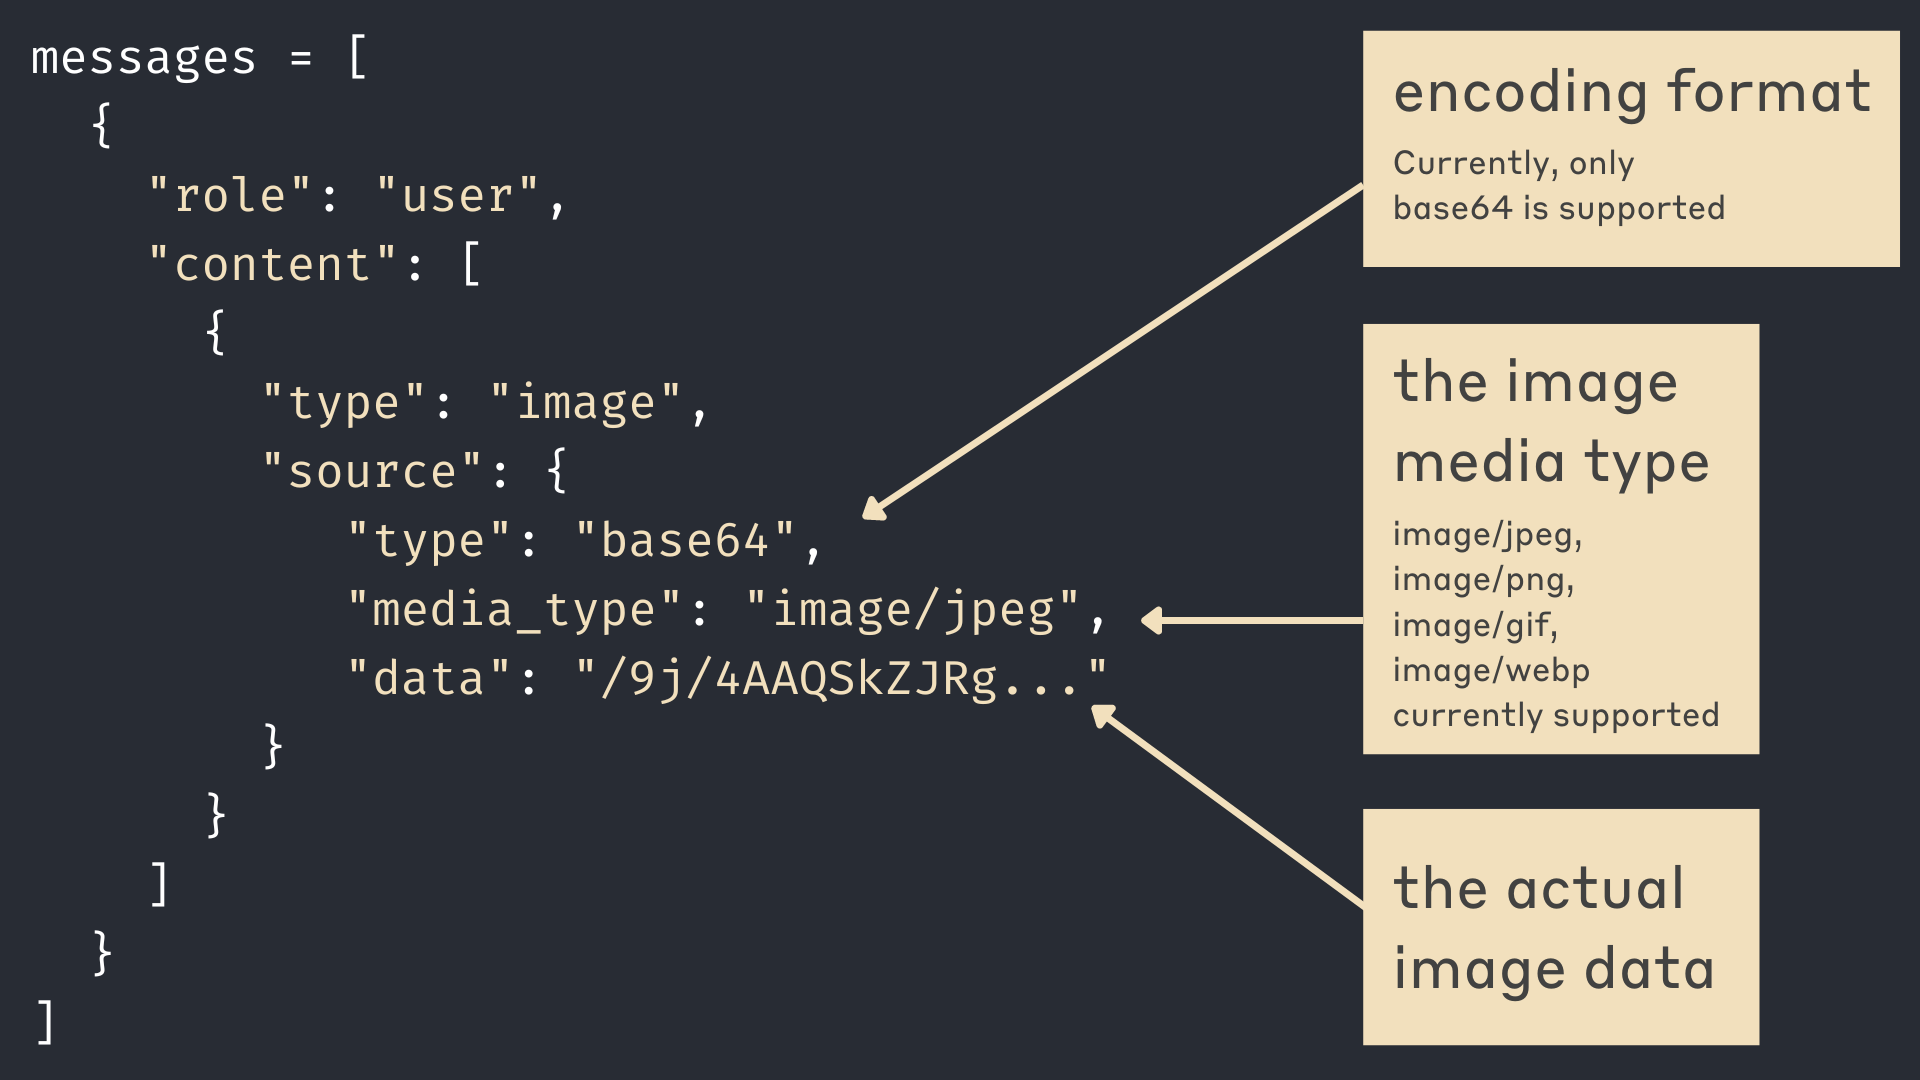

In [12]:
def create_image_message(base64_string: str, mime_type: str) -> Dict[str, Any]:
    # Create the image block with base64 encoded data
    image_block = {
        "type": "image",
        "source": {
            "type": "base64",
            "media_type": mime_type,
            "data": base64_string
        }
    }
    return image_block

In [13]:
def transcribe_single_page(image_data: str, mime_type: str) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                create_image_message(image_data, mime_type),
                {
                    "type": "text", 
                    "text": "transcribe the text from this page of a research paper as accurately as possible."
                }
            ]
        }
    ]

    response = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=4096,
        messages=messages
    )
    return response.content[0].text

In [14]:
def split_text(
    text, 
    chunk_size=200, 
    chunk_overlap=20
    ):
    chunks = []
    start = 0
    text_length = len(text)
    while start < text_length:
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end - chunk_overlap
    return chunks

In [ ]:
chunked_txt = []

for file_id, page in enumerate(images):
    transcribed_text = transcribe_single_page(base64_images[file_id], 'image/jpeg')
    chunks = split_text(transcribed_text, chunk_size=256, chunk_overlap=20)
    for chunk_id, chunk in enumerate(chunks):
        chunked_txt.append(
            {
                'id': f"{file_id}-{chunk_id}",
                'text': chunk,
            }
        )

print(chunked_txt)
print(f"Split in to {len(chunked_txt)} chunks\n\n")

In [ ]:
# upsert documents with embeddings to collection ChromaDB
for chunk in chunked_txt :
    collection.upsert(
            ids=chunk['id'],
            documents=chunk['text'],
    )

result = collection.get()

print(f"Collection {collection_name} has {len(result['ids'])} documents")
pprint.pprint(result)

In [8]:
def augment_query(query: str) -> str:
    prompt = "Provide an hypothetical answer to the given question."
    user_prompt = query + "\n" + prompt
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1024,
        messages=[{
            "role": "user",
            "content": user_prompt
        }]
    )
    return response.content[0].text

def query_collection(question: str, n_results: int) -> List[str]:
    results = collection.query(
        query_texts=question,
        n_results=n_results,
        # include=['embeddings', 'documents', 'distances']
    )
    # print(results)
    relevant_chunks = [txt for sublist in results["documents"] for txt in sublist]
    return relevant_chunks

def api_response(query: str, relevant_chunks: List[str]) -> str:
    context = relevant_chunks
    user_prompt = (f"""
                    You have been tasked with helping us to answer the following query: 
                    <query>
                    {query}
                    </query>
                    You have access to the following documents which are meant to provide context as you answer the query:
                    <documents>
                    {context}
                    </documents>
                    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
                    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
                    """
                    )
    
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2048,
        messages=[{
                "role": "user", 
                "content": user_prompt
                }],
        temperature=0

    )
    return response.content[0].text

In [ ]:
query = "What topics from HyDE are presented in paper?"
@trace_event()
def tracing_function(query: str) -> List[str]:
    augment_result = augment_query(query)
    relevant_chunks_result = query_collection(augment_result, 3)
    response = api_response(query, relevant_chunks_result)
    return response, augment_result, relevant_chunks_result

result = tracing_function(query)
print(result[0])